In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('../Bot_lane.csv')
lane = df.drop(columns = ['Lane', 'Unnamed: 0', 'Summoner', 'Item_0', 'Item_1', 'Item_2', 'Item_3', 'Item_4', 'Item_5', 'Item_6'])

In [3]:
lane.head()

,Champion,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls,champion_name
0,119,8,6,15,4,1,28325,8280,5501,16708,15237,16,1,22,15,Draven
1,67,3,3,11,2,1,20254,16638,11288,16945,12390,15,1,29,10,Vayne
2,236,0,4,4,0,0,11980,6513,1034,18400,8580,14,0,10,1,Lucian
3,29,9,7,16,4,2,30826,21118,8888,23092,15938,17,1,33,22,Twitch
4,15,2,6,6,0,1,12657,2828,2338,11386,8885,12,1,11,0,Sivir


# Lots of champions can be played in any lane due to one trick players getting auto-filled. So to make sure my clustering is built on sufficient data, I am filtering out champions who are played less than 5 times in this role.

In [4]:
for champ in list(lane.groupby('Champion').count().query("Kills < 5").index):
    lane = lane[lane['Champion'] != champ]                           

In [5]:
lane = lane.groupby("Champion").mean()

In [18]:
scalar = StandardScaler()
x = scalar.fit_transform(lane)

In [20]:
lane.head()

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls
Champion,,,,,,,,,,,,,,
15,5.288647,4.479938,7.434526,2.836081,1.446345,16600.297356,9753.073095,4366.347745,14228.845723,11296.866874,13.128149,1.981960,19.165163,1.236392
18,6.984496,4.715116,5.863372,3.532946,1.635659,15776.884690,11992.098837,5939.025194,15766.462209,11498.600775,13.008721,1.423450,18.541667,4.949612
21,5.897507,4.911357,7.168975,2.839335,1.448753,17207.792244,9025.329640,4780.260388,14839.786704,10726.387812,12.825485,1.642659,19.681440,6.717452
22,4.693122,5.108466,8.451058,2.318783,1.333333,15729.660053,8789.268519,3775.575397,14400.121693,10306.300265,12.728836,1.759259,21.625661,37.346561
29,7.353383,5.471178,6.939850,3.441103,1.641604,17508.145363,9274.736842,3055.894737,17274.132832,10955.155388,12.859649,1.370927,17.150376,13.172932


# To determine the optimal amount of clusters, I am going to run a loop of various K values and plot the errors to pick the ideal number of clusters based on where the "elbow" is.

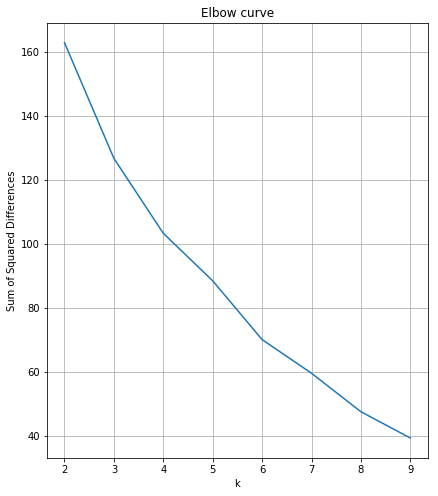

In [21]:
distorsions = []

for k in range(2,10):
    kmeans = KMeans(n_clusters=k, random_state = 301)
    kmeans.fit(x)
    distorsions.append(kmeans.inertia_)

# Plot values of SSE
plt.figure(figsize=(15,8))
plt.subplot(121, title='Elbow curve')
plt.xlabel('k')
plt.ylabel('Sum of Squared Differences')
plt.plot(range(2, 10), distorsions)
plt.grid(True)

There is no clear "elbow" here to easily determine the ideal number of clustes. As such, I am going to use the silhouette plot to determine the ideal number of clusters based on this data.

In [22]:
silhouette_plot = []
for k in range(2, 10):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(x)
    silhouette_avg = metrics.silhouette_score(lane, cluster_labels)
    silhouette_plot.append(silhouette_avg)

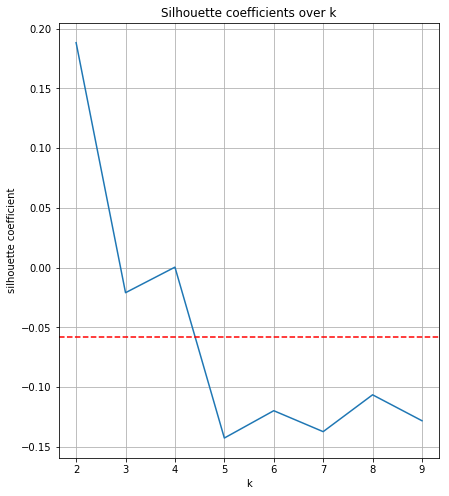

In [23]:
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(2, 10), silhouette_plot)
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
plt.grid(True)

The highest point, which also happens to be the second "elbow" is at 4 clusters and so I will use that to further analyze the playstyles in the bot lane.

In [10]:
k_means = KMeans(n_clusters = 4).fit(lane.groupby('Champion').mean())
cluster_assignments = k_means.predict(lane.groupby('Champion').mean())

In [11]:
cluster_assignments

array([2, 1, 2, 2, 0, 1, 0, 3, 2, 1, 1, 2, 1, 0, 0, 1], dtype=int32)

In [12]:
clustered = lane.groupby('Champion').mean()

In [13]:
clustered['Cluster'] = cluster_assignments

In [14]:
clustered.groupby("Cluster").count()['Kills']

Cluster
0    4
1    6
2    5
3    1
Name: Kills, dtype: int64

There are 5 champions in Cluster 0, 4 champions in cluster 1, 6 champions in cluster 2, and ONLY 1 champion in cluster 3. 

In [15]:
clustered.groupby("Cluster").mean()

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls
Cluster,,,,,,,,,,,,,,
0,6.538876,5.261884,6.249906,3.167202,1.575258,16141.664249,9811.543989,3778.428536,17046.542773,10980.747394,12.845433,1.794363,18.968434,9.779927
1,6.258626,4.873880,6.176589,3.194782,1.553558,16419.047621,11498.247030,5012.535624,14956.005446,11334.046121,12.846102,1.558106,17.838343,9.830942
2,5.591661,4.831621,7.501486,2.851194,1.428020,16458.101884,9024.284584,4104.229508,14383.139212,10832.190068,12.893684,1.801244,19.092777,16.665249
3,5.571811,4.839429,6.785608,2.896224,1.440975,20068.118347,8537.082962,3593.548320,14395.771930,11191.202795,12.969373,1.746952,19.119833,6.044008


# Based on the average values of the clusters above, it looks like the one champion in Cluster 2 had an outlier performance where the values are drastically different from every other cluster.

In [16]:
champion_names = 'http://ddragon.leagueoflegends.com/cdn/9.13.1/data/en_US/champion.json?fbclid=IwAR3wpqEjCmWqLKToVoMwWz-iGVCkHaVVfVOWtvy9OpfKrM7Hjt1YZ4VyPk8'

df = pd.read_json(champion_names)

champs = []
ids = []
for names in list(df['data']):
    champs.append(names['id'])
    ids.append(names['key'])

champ_dict = {}

for champ in range(len(champs)):
    champ_dict[ids[champ]] = champs[champ]

clustered['champion_name'] = clustered.index.map(lambda x: champ_dict[str(x)] )



In [22]:
clustered[clustered['Cluster'] == 2]

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls,Cluster,champion_name
Champion,,,,,,,,,,,,,,,,
15,5.288647,4.479938,7.434526,2.836081,1.446345,16600.297356,9753.073095,4366.347745,14228.845723,11296.866874,13.128149,1.981960,19.165163,1.236392,2,Sivir
21,5.897507,4.911357,7.168975,2.839335,1.448753,17207.792244,9025.329640,4780.260388,14839.786704,10726.387812,12.825485,1.642659,19.681440,6.717452,2,MissFortune
22,4.693122,5.108466,8.451058,2.318783,1.333333,15729.660053,8789.268519,3775.575397,14400.121693,10306.300265,12.728836,1.759259,21.625661,37.346561,2,Ashe
110,6.391389,5.039139,6.876712,3.205479,1.465753,16877.902153,8973.405088,4106.203523,14046.927593,10969.954990,12.835616,1.837573,18.332681,21.694716,2,Varus
202,5.687638,4.619205,7.576159,3.056291,1.445916,15874.857616,8580.346578,3492.760486,14400.014349,10861.440397,12.950331,1.784768,16.658940,16.331126,2,Jhin


In [18]:
clustered.groupby('Cluster').mean()

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls
Cluster,,,,,,,,,,,,,,
0,6.538876,5.261884,6.249906,3.167202,1.575258,16141.664249,9811.543989,3778.428536,17046.542773,10980.747394,12.845433,1.794363,18.968434,9.779927
1,6.258626,4.873880,6.176589,3.194782,1.553558,16419.047621,11498.247030,5012.535624,14956.005446,11334.046121,12.846102,1.558106,17.838343,9.830942
2,5.591661,4.831621,7.501486,2.851194,1.428020,16458.101884,9024.284584,4104.229508,14383.139212,10832.190068,12.893684,1.801244,19.092777,16.665249
3,5.571811,4.839429,6.785608,2.896224,1.440975,20068.118347,8537.082962,3593.548320,14395.771930,11191.202795,12.969373,1.746952,19.119833,6.044008


# 